In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_surface_area_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(20, 90, 71)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:71,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((71,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_87128/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.


Iter. Eval. Time m:s
0     3       0:02.0
1     510     0:46.3
2     993     1:12.9
3     1470    1:17.4
20    8187    2:10.5
40    14289   2:28.6
60    19920   2:43.2
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8784077873747D+02   r2 =  0.3649500999976D-12


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.7975383496972D+02   r2 =  0.2514817737045D-09
80    25380   3:37.5
100   30840   4:04.1
120   36204   4:35.8
140   41187   5:00.4
160   46806   5:14.5
180   51957   5:27.6
200   57297   5:45.9
220   62712   6:01.1
240   68196   6:14.3
260   73470   6:27.4
280   78870   6:40.4
300   84432   7:08.5
320   89937   7:21.8
340   94995   7:37.3
360   100332   7:50.0
380   105822   8:26.4
400   111054   8:38.8
420   116247   8:50.9
440   121656   9:05.2
460   126921   9:20.4
480   132423   9:35.7
500   137703   9:47.7
520   143052  10:00.0
540   148338  10:14.2
560   153624  10:28.7
580   159162  10:41.5
600   164439  10:53.9


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.7050135303423D+02   r2 =  0.2806698439782D-08
620   169827  11:21.5
640   175320  11:34.8
660   180522  11:56.5
680   185727  12:11.4
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.7879726163585D+02   r2 =  0.1282769579289D-13
700   190932  12:44.9
720   196344  13:02.2
740   201702  13:23.4
760   206976  13:38.8
780   212184  13:52.5
800   217353  14:12.7
820   222831  14:27.1
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8805952247702D+02   r2 =  0.1428574750687D-11
840   228399  15:03.2
860   233805  15:39.4
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.5094982018

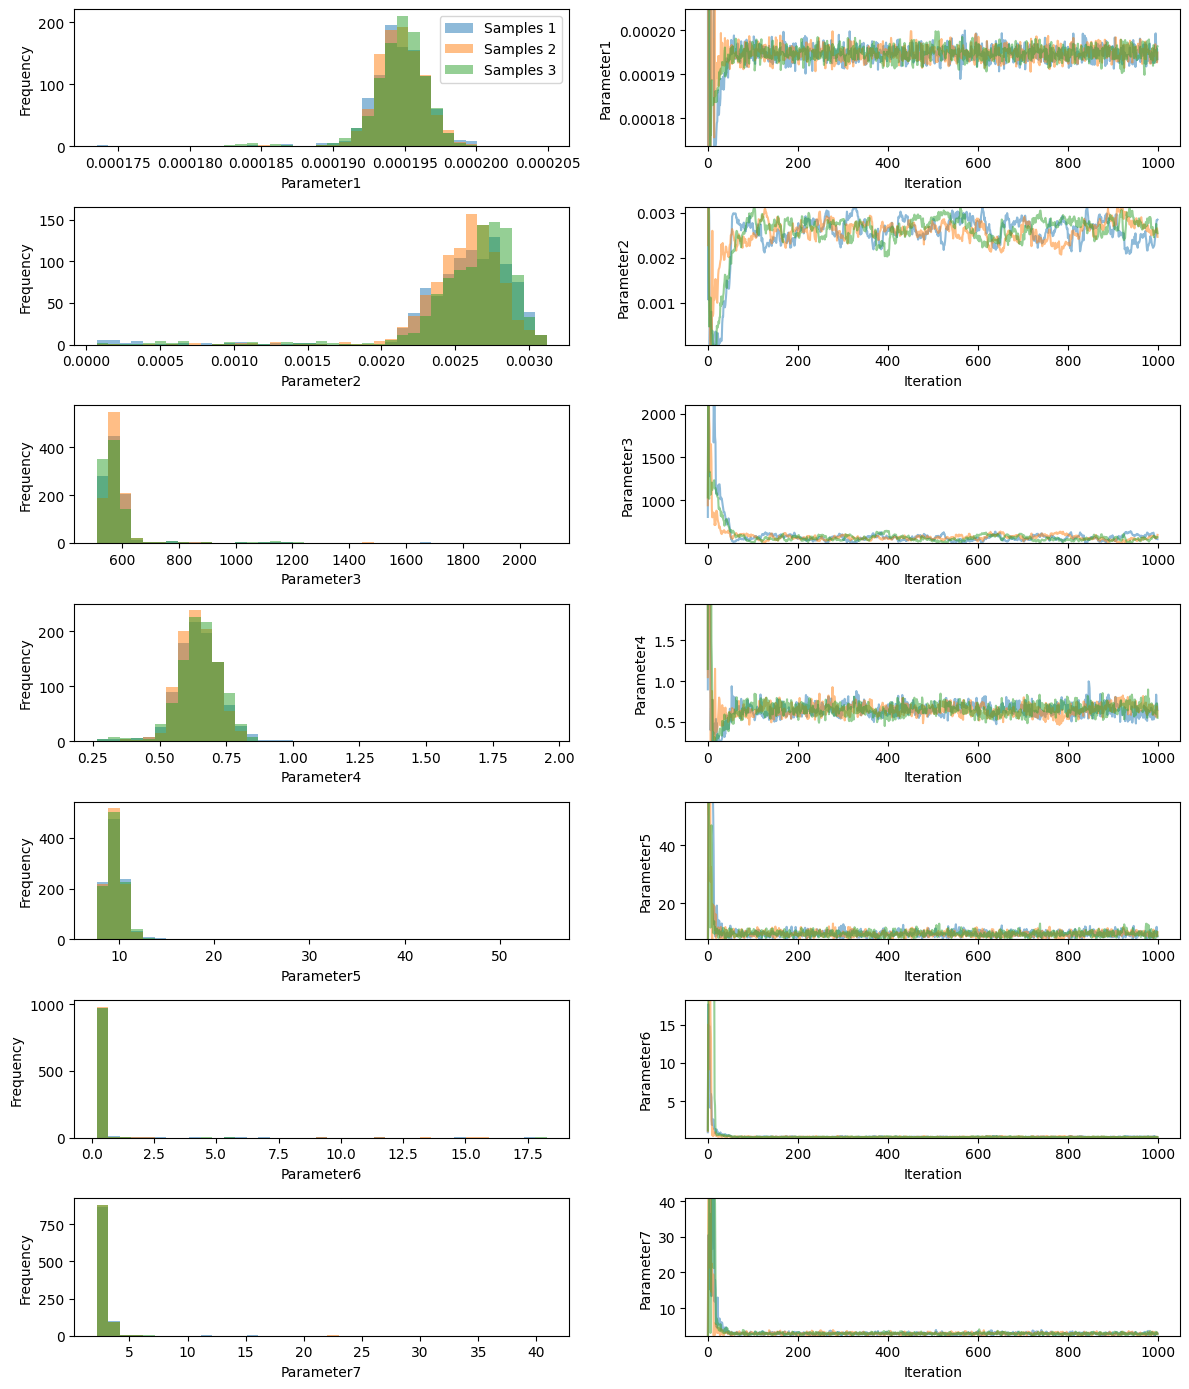

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [24]:

y0 = np.array([0.0003, 0.01, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8204693401359D+02   r2 =  0.1352526083961D-11
Estimated parameters:
[1.94857283e-04 2.66516481e-03 5.64606090e+02 6.45051688e-01
 9.37117641e+00 2.73887137e-01 2.74870638e+00]
Estimated parameters:
[1.94857282e-04 2.66516477e-03 5.64606095e+02 6.45051699e-01
 9.37117664e+00 2.73887145e-01 2.74870618e+00]
Estimated parameters:
[3.e-04 1.e-03 9.e+02 6.e+00 6.e+00 6.e+00 6.e+00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_optimisers/_xnes.py:82: UserWarning: All points requested by XNES are outside the boundaries.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.8785872604692D+02   r2 =  0.5144411537908D-09
Estimated parameters:
[1.94857282e-04 2.66516470e-03 5.64606104e+02 6.45051721e-01
 9.37117647e+00 2.73887157e-01 2.74870638e+00]
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.7381319013175D+02   r2 =  0.4801307932131D-10
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.6406350492411D+02   r2 =  0.3058742467447D-10
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.6636460481354D+02   r2 =  0.1610930368504D-09
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in abo

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.2000000000000D+02   r2 =  0.2782509626842D-09
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.6402428218814D+02   r2 =  0.4448127280451D-14
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.7316709482274D+02   r2 =  0.1472168329939D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.8661743284741D+02   r2 =  0.3872886622495D-08
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.7124646933509D+

In [25]:
print(log_likelihood([1.94857283e-04, 2.66516472e-03, 5.64606098e+02, 6.45051721e-01,
 9.37117639e+00, 2.73887150e-01, 2.74870635e+00]))

AIC = 2*7 - 2*log_likelihood([1.94857283e-04, 2.66516472e-03, 5.64606098e+02, 6.45051721e-01,
 9.37117639e+00, 2.73887150e-01, 2.74870635e+00])

print(AIC)

-510.5652045234086
1035.1304090468172


In [10]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[1.93783452e-04 2.75586101e-03 5.60940635e+02 6.08008715e-01
 9.40802682e+00 3.08019301e-01 2.74339507e+00]
[[1.93783452e-04 2.75586101e-03 5.60940635e+02 ... 9.40802682e+00
  3.08019301e-01 2.74339507e+00]
 [1.93107950e-04 2.58278697e-03 5.61125905e+02 ... 9.79437914e+00
  3.04138578e-01 2.77146920e+00]
 [1.98639537e-04 2.57384290e-03 5.65194818e+02 ... 9.96749286e+00
  2.73285093e-01 2.68670820e+00]
 ...
 [1.92780190e-04 2.83209843e-03 5.55722566e+02 ... 1.19802692e+01
  2.23665041e-01 3.08465578e+00]
 [1.95722242e-04 2.83094920e-03 5.55541839e+02 ... 8.57309814e+00
  2.09194408e-01 2.87522173e+00]
 [1.93437928e-04 2.84344511e-03 5.54201839e+02 ... 8.63626757e+00
  2.32729884e-01 2.88169637e+00]]


In [11]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


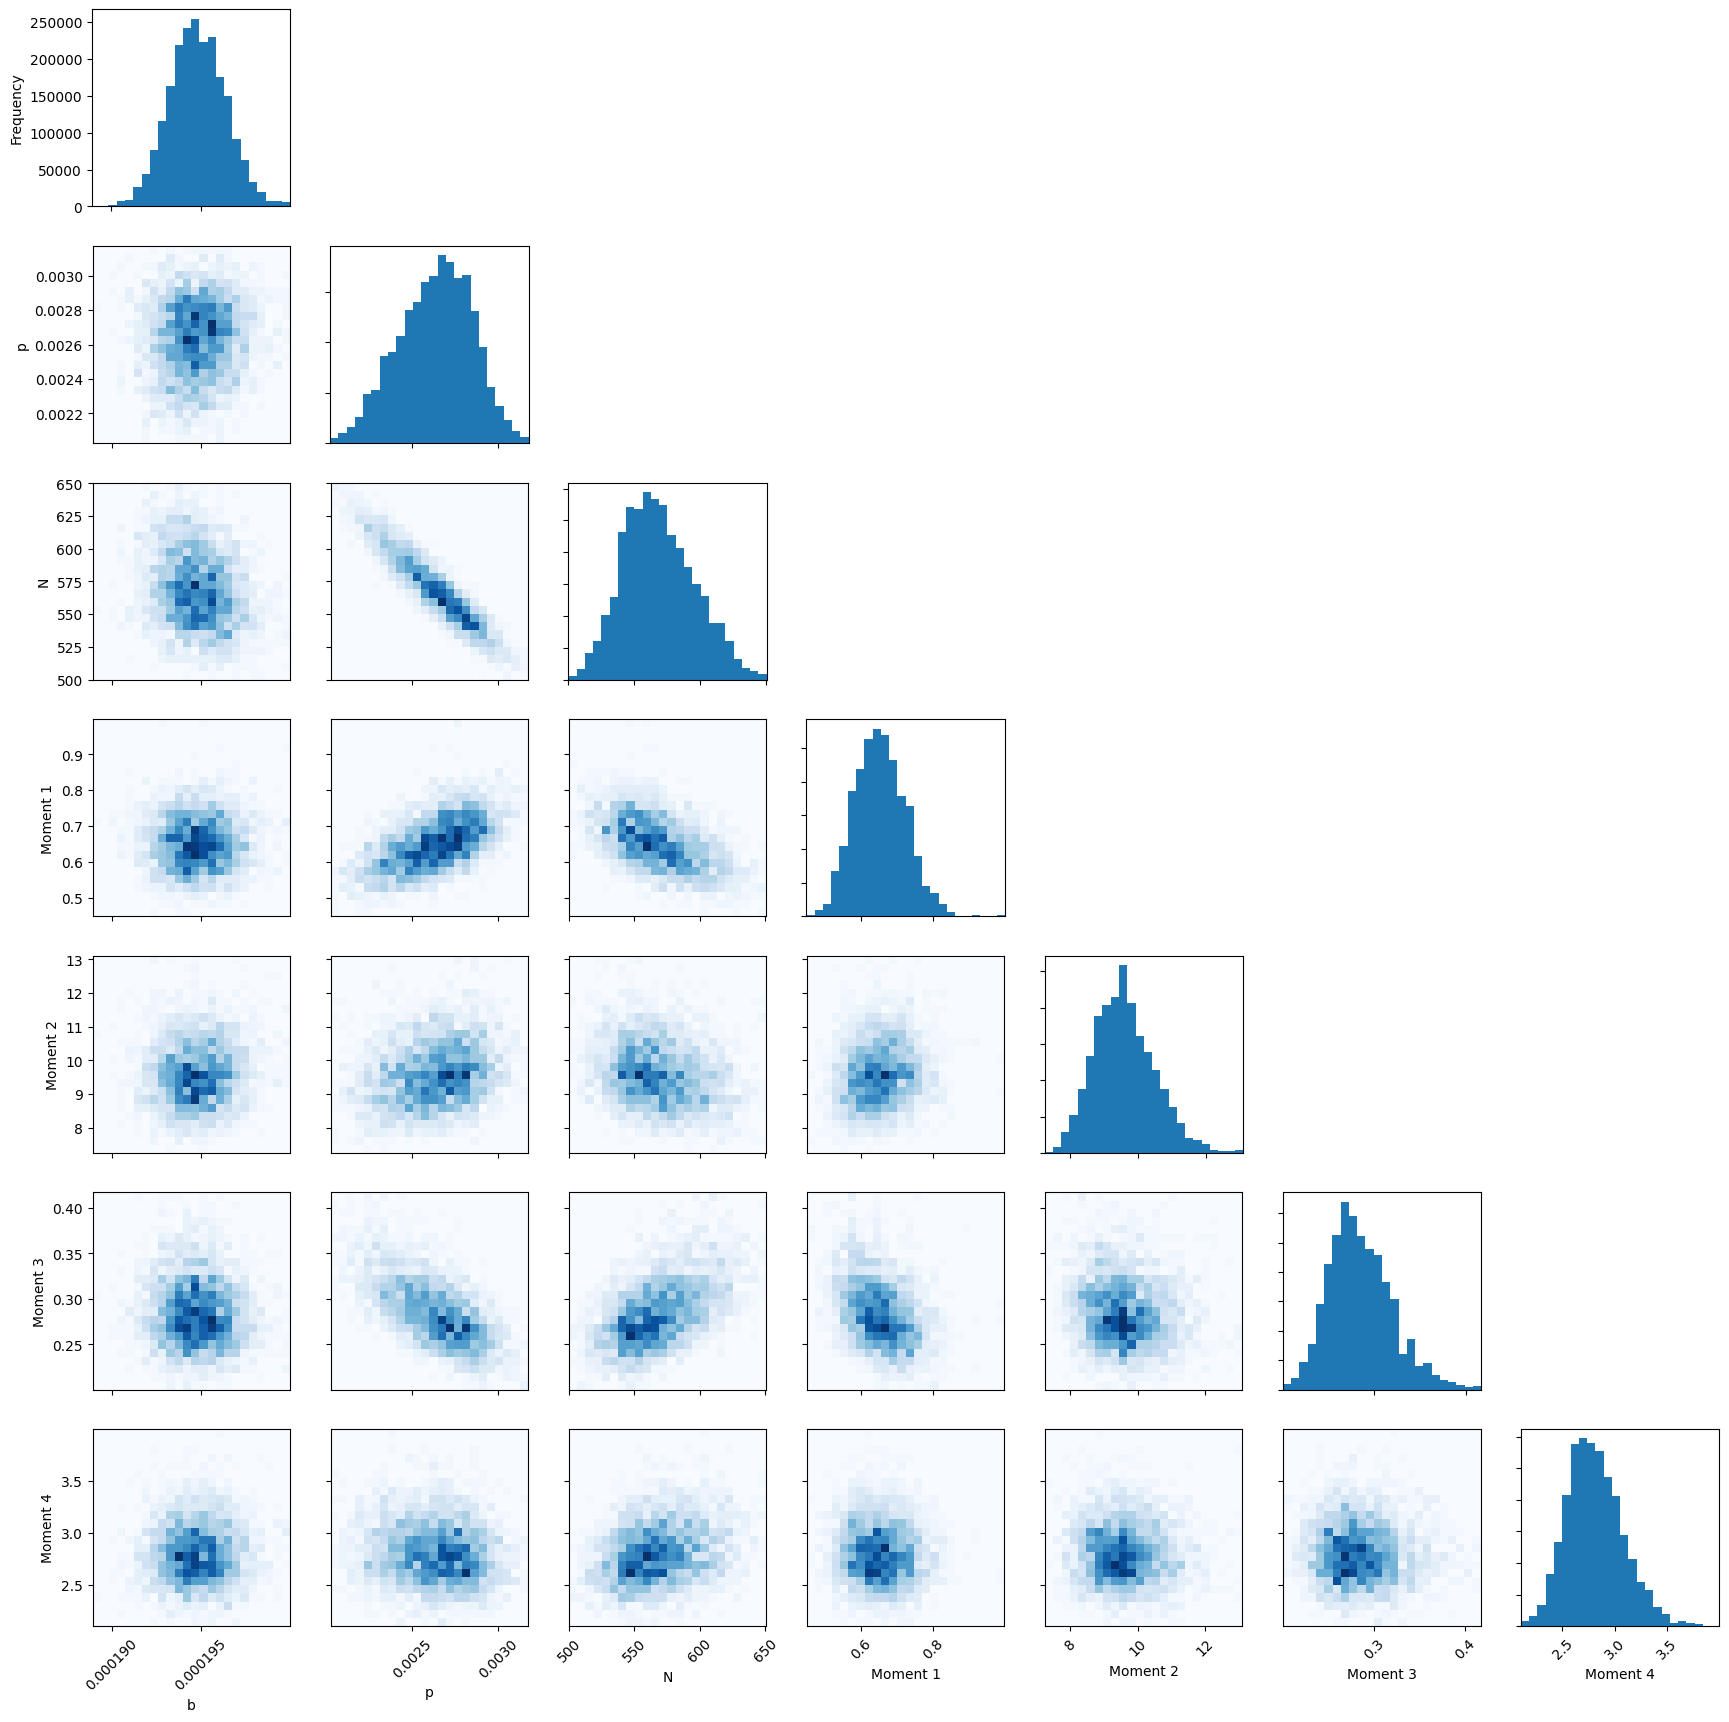

In [12]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

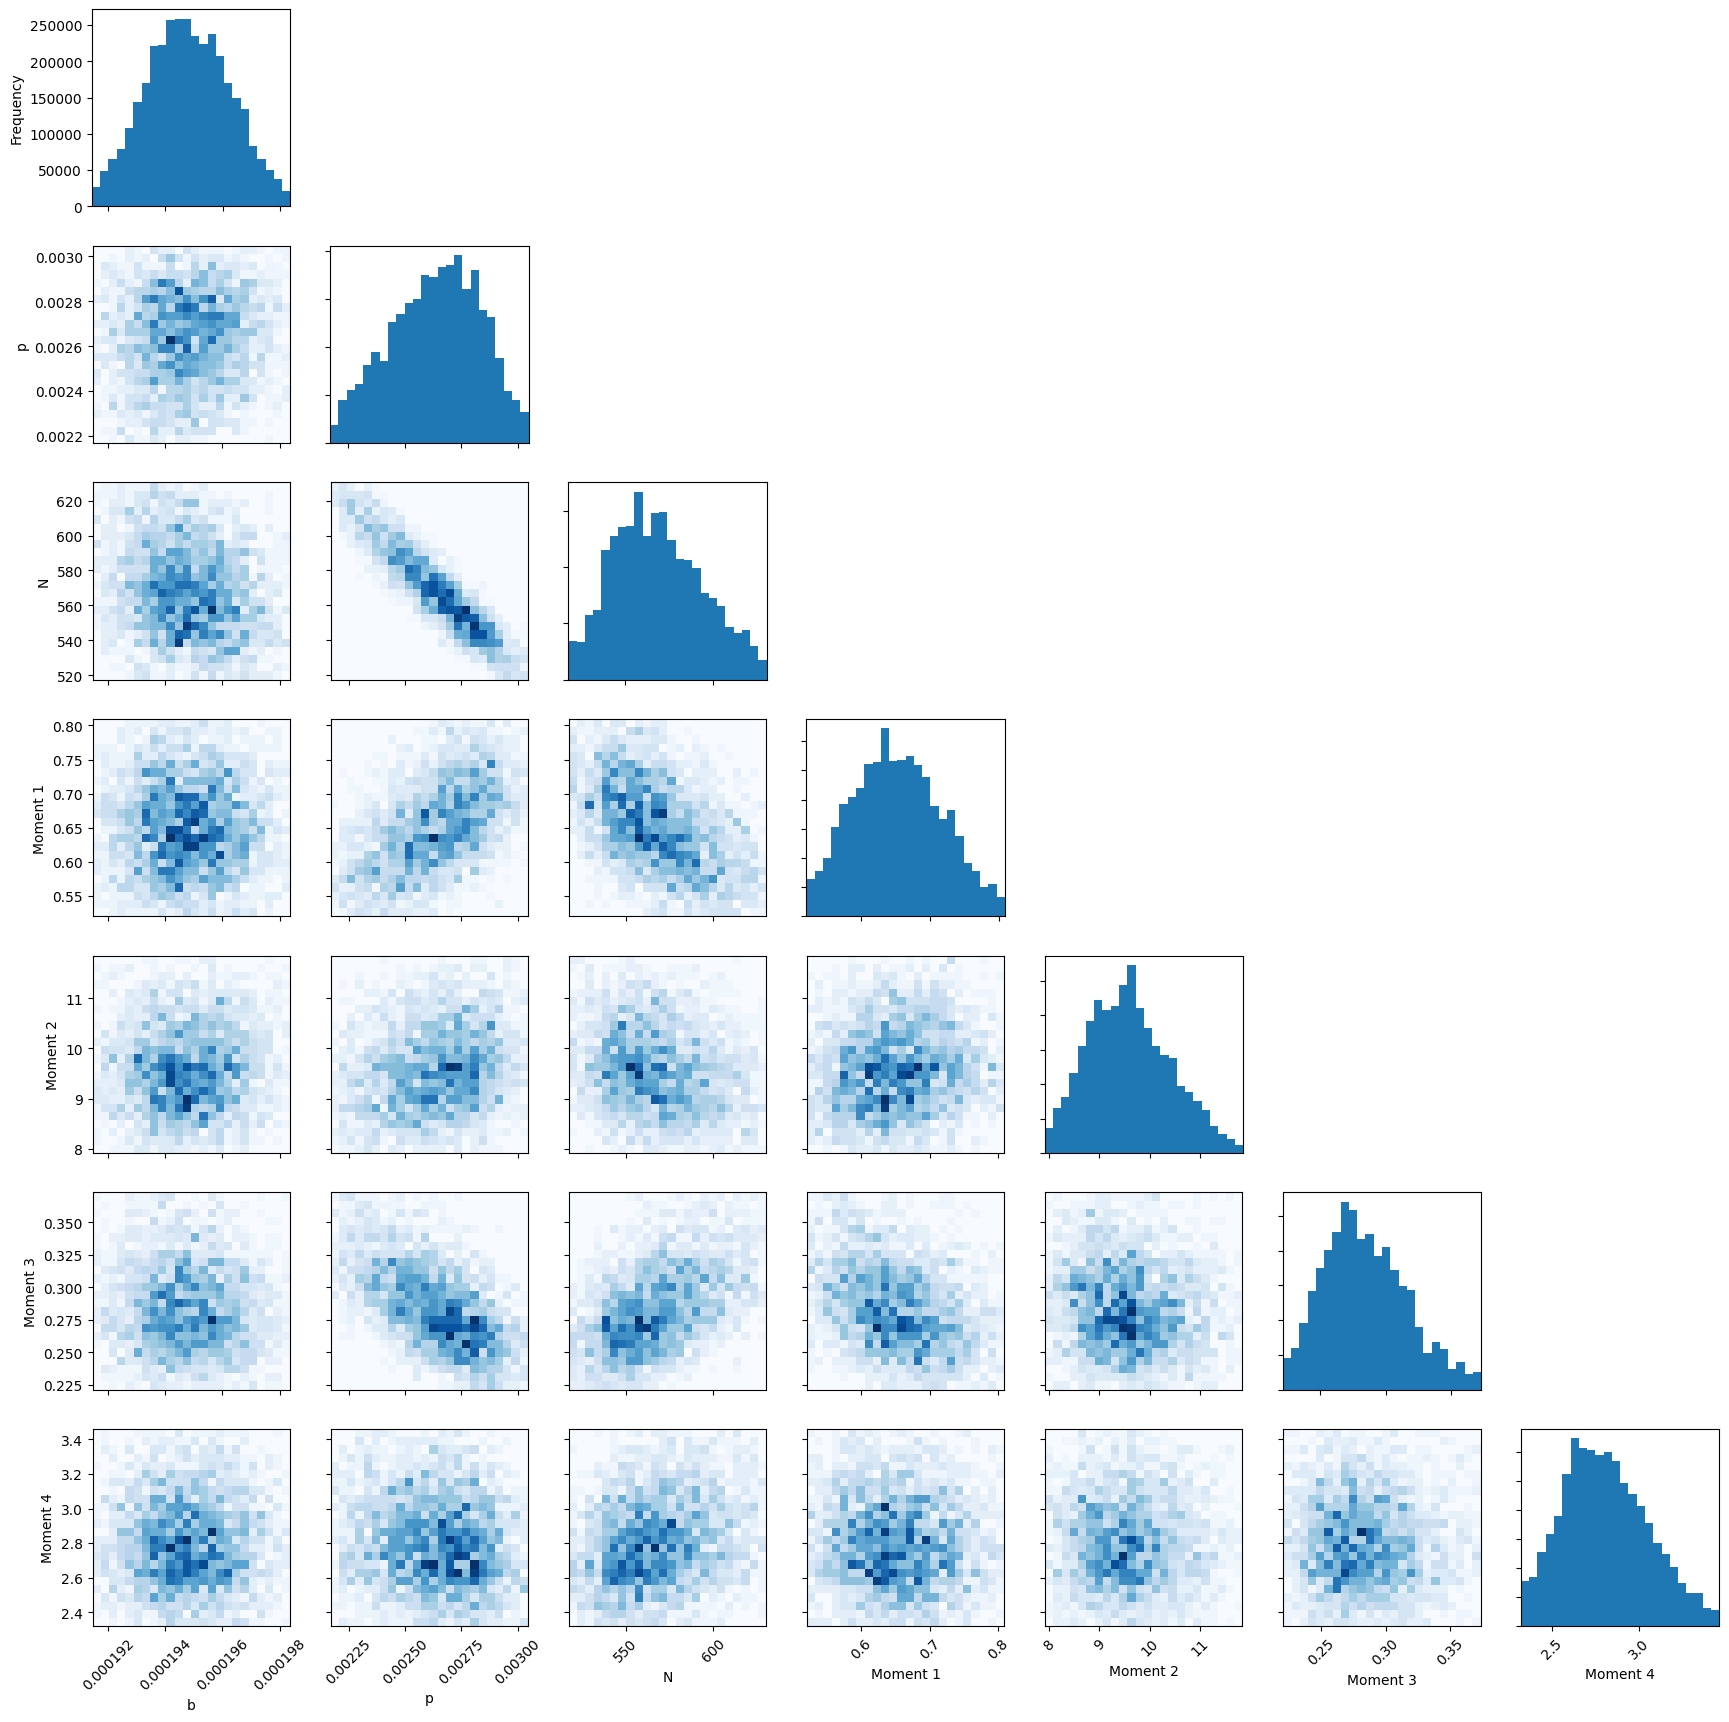

In [13]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

[1.93783452e-04 2.75586101e-03 5.60940635e+02 6.08008715e-01
 9.40802682e+00 3.08019301e-01 2.74339507e+00]


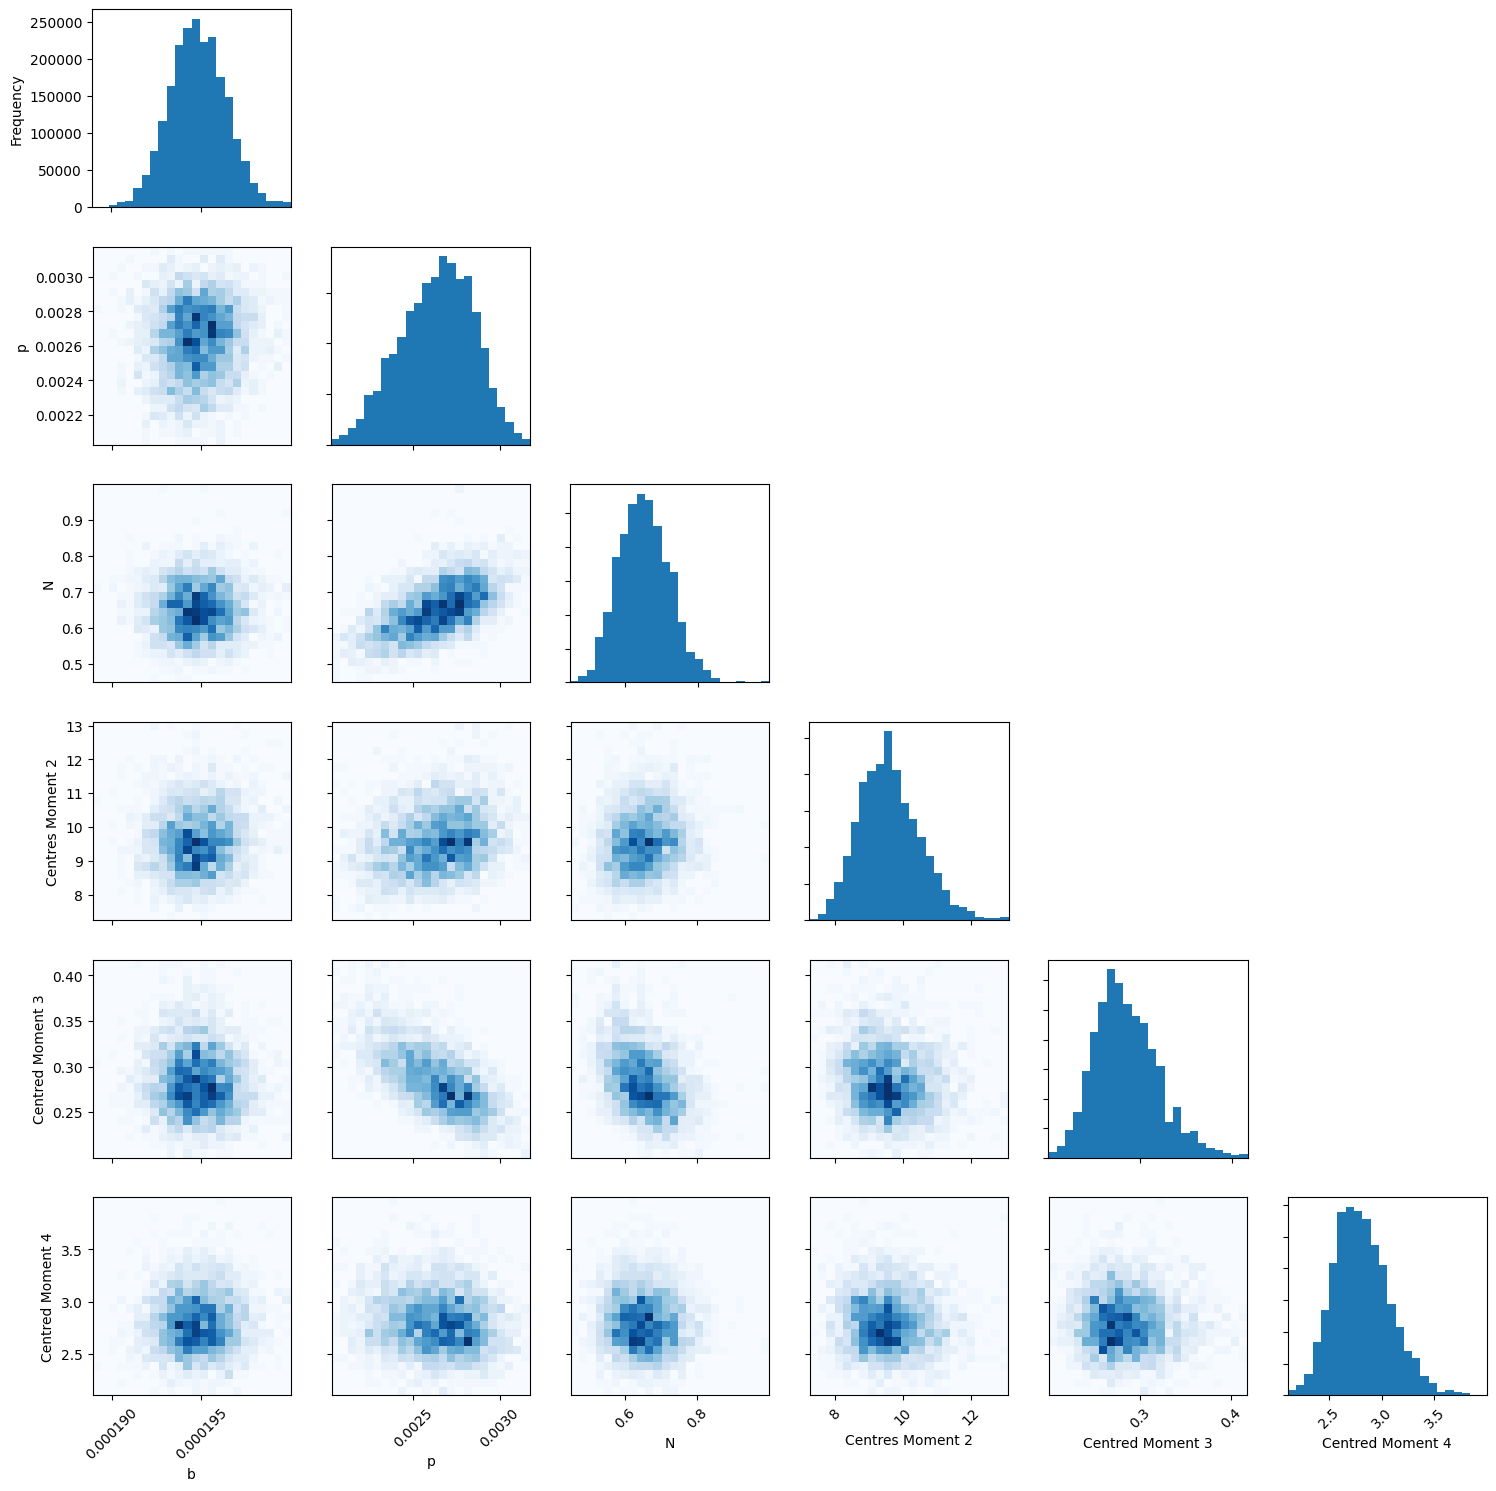

In [14]:
parameter_names = ["b","p","N", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5,6]], heatmap=True, 
                    parameter_names=["b","p","N", "Centres Moment 2", "Centred Moment 3", "Centred Moment 4"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [15]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.00    388.70  0.36
p         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.06    38.79   0.04
N         568.28  28.85   518.62  546.43  565.29  589.02  626.36   1.06    41.30   0.04
Moment 1  0.65    0.07    0.53    0.60    0.65    0.70    0.80     1.01    94.52   0.09
Moment 2  9.61    0.87    8.10    8.97    9.55    10.15   11.50    1.00    392.87  0.37
Moment 3  0.29    0.04    0.22    0.26    0.28    0.31    0.37     1.02    78.31   0.07
Moment 4  2.80    0.27    2.34    2.62    2.78    2.98    3.36     1.00    386.70  0.36


In [16]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [17]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000195  1.59e-06  0.000192  0.000194  0.000195  0.000196  0.000198  1       389    0.365
p         0.00264   0.000224  0.00219   0.00248   0.00266   0.00281   0.00302   1.06    38.8   0.0364
N         568       28.8      519       546       565       589       626       1.06    41.3   0.0387
Moment 1  0.655     0.0712    0.528     0.604     0.653     0.703     0.797     1.01    94.5   0.0887
Moment 2  9.61      0.875     8.1       8.97      9.55      10.2      11.5      1       393    0.369
Moment 3  0.286     0.0363    0.225     0.26      0.281     0.307     0.367     1.02    78.3   0.0735
Moment 4  2.8       0.269     2.34      2.62      2.78      2.98      3.36      1       387    0.363


In [29]:
import math
print(math.log(4))
results.mean()

print(len(results.mean()))

AIC = 2*len(results.mean()) - 2*log_likelihood(results.mean())

print(AIC)


BIC = len(results.mean())*math.log(4) - 2*log_likelihood(results.mean())

print(BIC)

1.3862943611198906
7
1035.538162522036
1031.242223049875


In [30]:
shape_chains = np.shape(AllChains)

DIC_1 = 0
for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    DIC_1 += -2*log_likelihood(thetas)

DIC_1 = DIC_1/shape_chains[0]

DIC_2 = -2*log_likelihood(results.mean())

DIC = 2*DIC_1 - DIC_2

print(DIC)

1035.920854199552


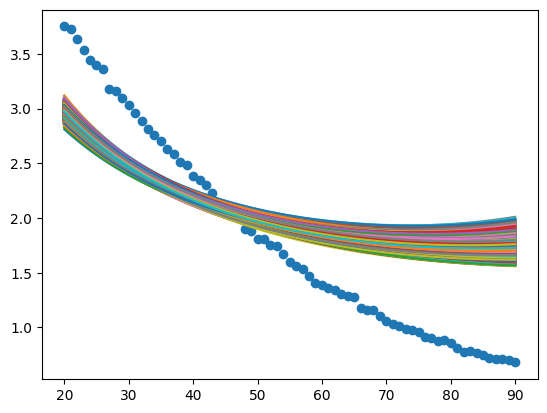

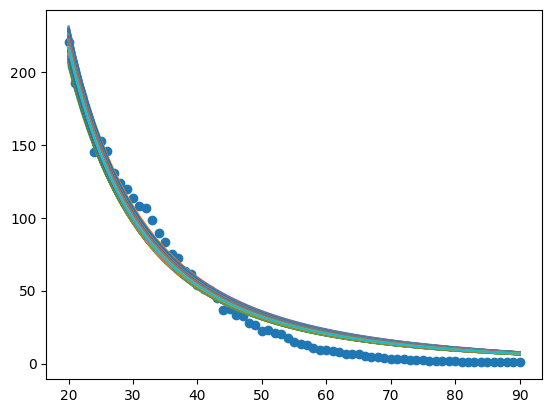

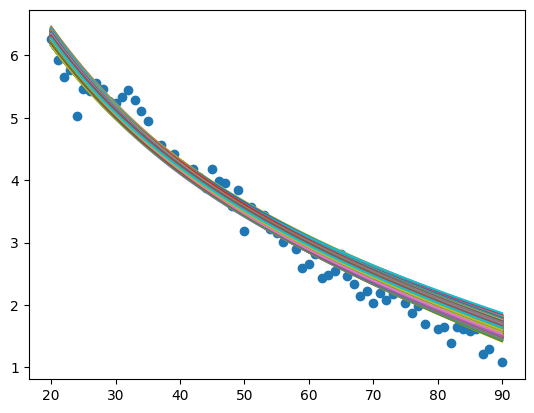

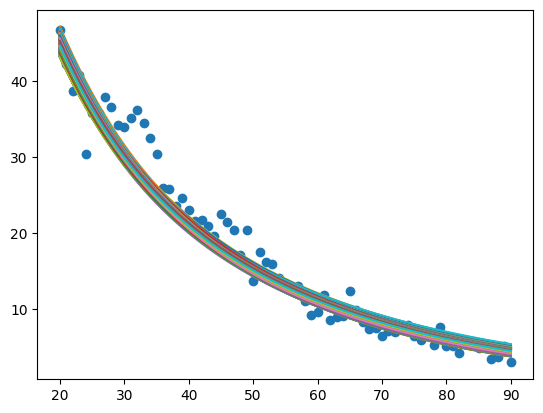

In [32]:
shape_chains = np.shape(AllChains)



data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

plt.figure(1)
plt.scatter(times, data_mean)
plt.figure(2)
plt.scatter(times, data_variance)
plt.figure(3)
plt.scatter(times, data_skewness)
plt.figure(4)
plt.scatter(times, data_kurtosis)

for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    values = model.simulate(thetas[[0,1,2]], times)
    plt.figure(1)
    plt.plot(times,values[:,0])
    plt.figure(2)
    plt.plot(times,values[:,1])
    plt.figure(3)
    plt.plot(times,values[:,2])
    plt.figure(4)
    plt.plot(times,values[:,3])

plt.show()
plt.show()
plt.show()
plt.show()

In [ ]:
import scipy as spy

KS_test_array = []
for i in range(71):
    KS_test = spy.stats.kstest(result_interested[i,:], org_values[i,:])
    KS_test_array = np.append(KS_test_array, KS_test.statistic)

plt.plot(KS_test_array)

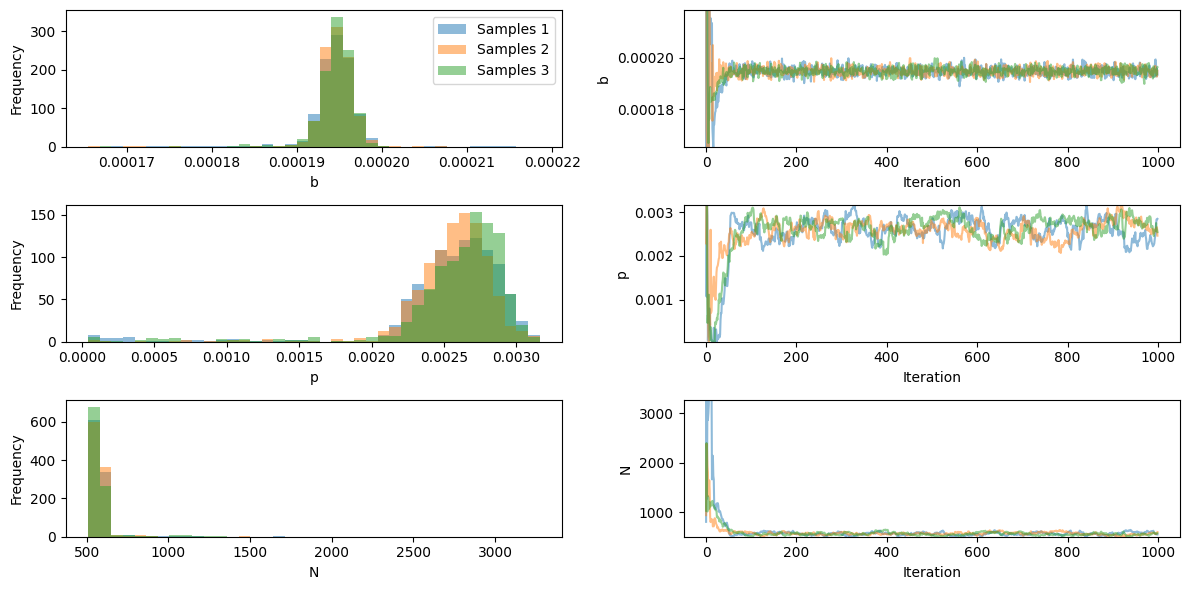

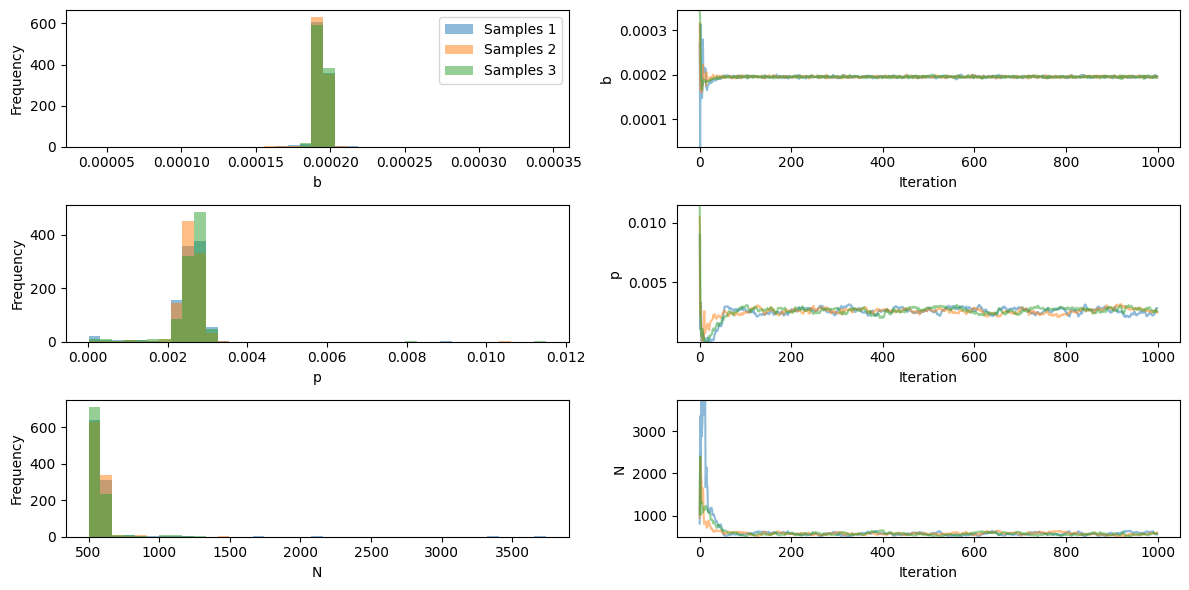

In [18]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

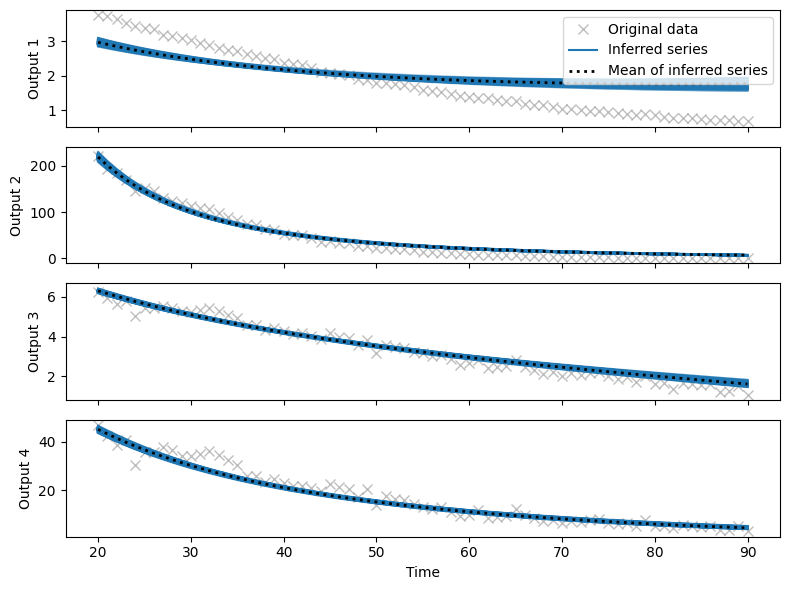

In [19]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

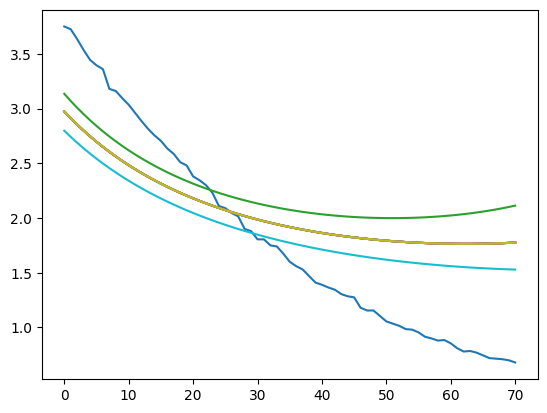

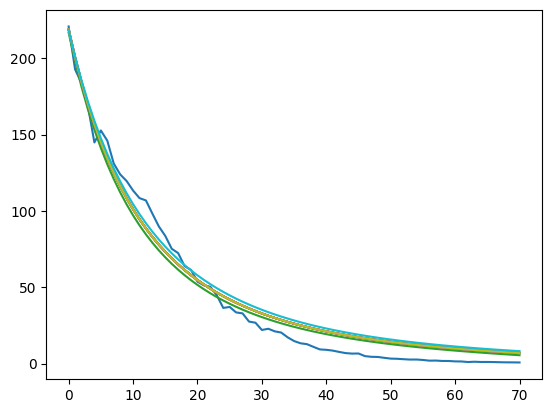

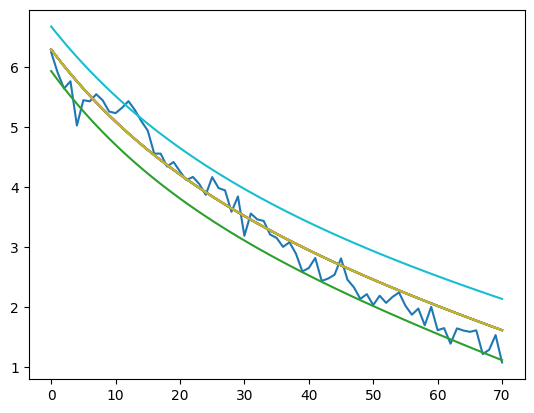

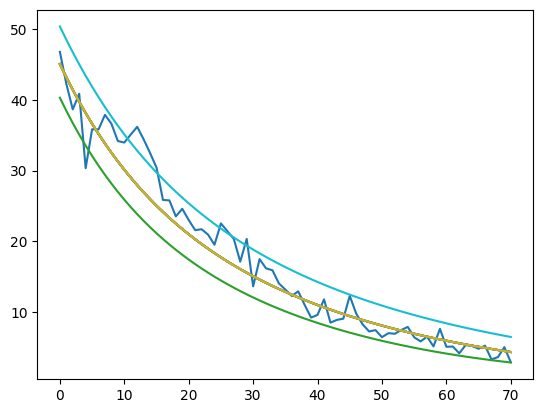

In [27]:


data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

CI_0 = means

CI_1 = means + 2*st_devs

CI_2 = means
CI_2[0] += 2*st_devs[0]
CI_2[1] += 2*st_devs[1] 
CI_2[2] -= 2*st_devs[2]

CI_3 = means
CI_3[0] += 2*st_devs[0]
CI_3[1] -= 2*st_devs[1] 
CI_3[2] += 2*st_devs[2]

CI_4 = means
CI_4[0] -= 2*st_devs[0]
CI_4[1] += 2*st_devs[1] 
CI_4[2] += 2*st_devs[2]

CI_5 = means
CI_5[0] += 2*st_devs[0]
CI_5[1] -= 2*st_devs[1] 
CI_5[2] -= 2*st_devs[2]

CI_6 = means
CI_6[0] -= 2*st_devs[0]
CI_6[1] += 2*st_devs[1] 
CI_6[2] -= 2*st_devs[2]

CI_7 = means
CI_7[0] -= 2*st_devs[0]
CI_7[1] -= 2*st_devs[1] 
CI_7[2] += 2*st_devs[2] 

CI_8 = means - 2*st_devs

values_0 = model.simulate(CI_0, times)
values_1 = model.simulate(CI_1, times)
values_2 = model.simulate(CI_2, times)
values_3 = model.simulate(CI_3, times)
values_4 = model.simulate(CI_4, times)
values_5 = model.simulate(CI_5, times)
values_6 = model.simulate(CI_6, times)
values_7 = model.simulate(CI_7, times)
values_8 = model.simulate(CI_8, times)
# print(np.shape(values))

plt.plot(data_mean)
plt.plot(values_0[:,0])
plt.plot(values_1[:,0])
plt.plot(values_2[:,0])
plt.plot(values_3[:,0])
plt.plot(values_4[:,0])
plt.plot(values_5[:,0])
plt.plot(values_6[:,0])
plt.plot(values_7[:,0])
plt.plot(values_8[:,0])
plt.show()



plt.plot(data_variance)
plt.plot(values_0[:,1])
plt.plot(values_1[:,1])
plt.plot(values_2[:,1])
plt.plot(values_3[:,1])
plt.plot(values_4[:,1])
plt.plot(values_5[:,1])
plt.plot(values_6[:,1])
plt.plot(values_7[:,1])
plt.plot(values_8[:,1])
plt.show()


plt.plot(data_skewness)
plt.plot(values_0[:,2])
plt.plot(values_1[:,2])
plt.plot(values_2[:,2])
plt.plot(values_3[:,2])
plt.plot(values_4[:,2])
plt.plot(values_5[:,2])
plt.plot(values_6[:,2])
plt.plot(values_7[:,2])
plt.plot(values_8[:,2])
plt.show()

plt.plot(data_kurtosis)
plt.plot(values_0[:,3])
plt.plot(values_1[:,3])
plt.plot(values_2[:,3])
plt.plot(values_3[:,3])
plt.plot(values_4[:,3])
plt.plot(values_5[:,3])
plt.plot(values_6[:,3])
plt.plot(values_7[:,3])
plt.plot(values_8[:,3])
plt.show()

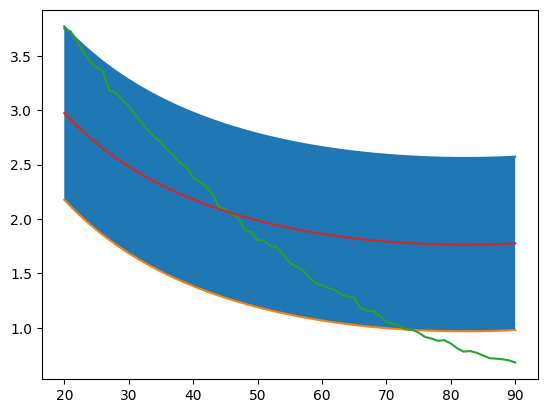

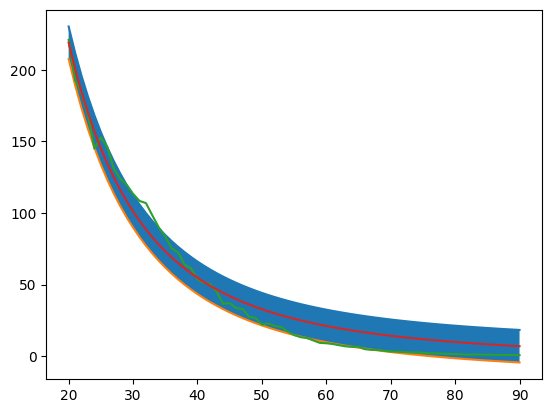

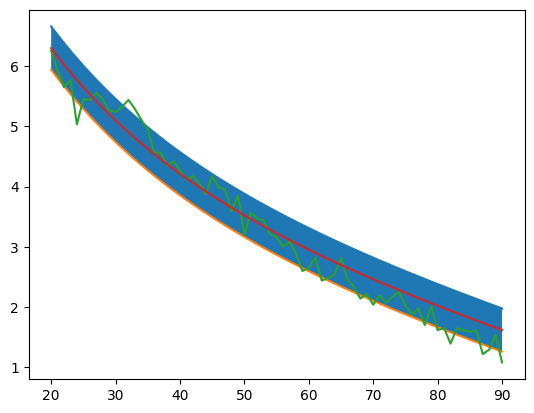

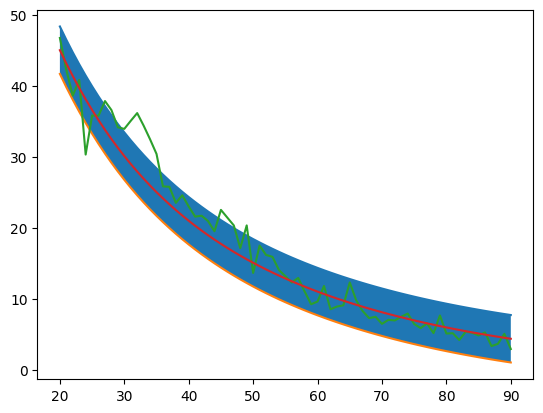

In [28]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

mean_CI = results.mean()[[3,4,5,6]]
st_devs_CI = results.std()[[3,4,5,6]]

CI_0 = means


values_0 = model.simulate(CI_0, times)
x=np.linspace(20,90,71)

y1=values_0[:,0]+mean_CI[0]+2*st_devs_CI[0]
y2=values_0[:,0]-mean_CI[0]-2*st_devs_CI[0]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_mean)
plt.plot(x,values_0[:,0])
plt.show()

y1=values_0[:,1]+mean_CI[1]+2*st_devs_CI[1]
y2=values_0[:,1]-mean_CI[1]-2*st_devs_CI[1]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_variance)
plt.plot(x,values_0[:,1])
plt.show()

y1=values_0[:,2]+mean_CI[2]+2*st_devs_CI[2]
y2=values_0[:,2]-mean_CI[2]-2*st_devs_CI[2]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_skewness)
plt.plot(x,values_0[:,2])
plt.show()


y1=values_0[:,3]+mean_CI[3]+2*st_devs_CI[3]
y2=values_0[:,3]-mean_CI[3]-2*st_devs_CI[3]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_kurtosis)
plt.plot(x,values_0[:,3])
plt.show()


Mass 787.7250764651566


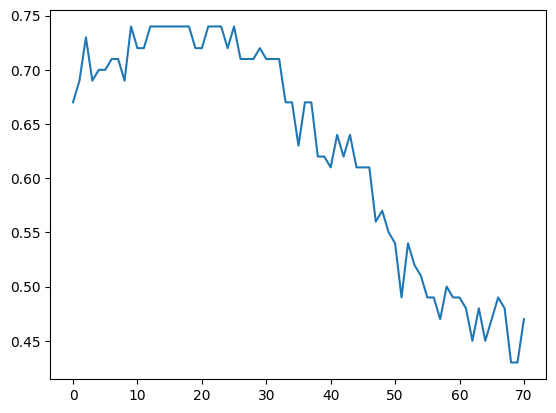

In [34]:
import scipy as spy 
from scipy.integrate import odeint

import smol_ODE_Pro_SA

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
N_max = 100

means = results.mean()

b = means[0]
m = means[1]
N = means[2]
## Running of solver
tmin = 1
tmax = 145
# tmax = 1000
tspan = np.linspace(tmin, tmax, 145)

## IC 
# (set to allow for metastatic invasion)

n0 = np.zeros((N_max))
n0[0] = N


result = odeint(smol_ODE_Pro_SA.ext_smol,n0,tspan,args = (b,m,N_max))

final_time = result[-1,:]

N_t = 0
for i in range(len(final_time)):
    N_t += (i+1)*final_time[i]

print('Mass', N_t)



result_interested = result[19:,:]





KS_test_array = []
for i in range(71):
    KS_test = spy.stats.kstest(result_interested[i,:], org_values[i,:])
    KS_test_array = np.append(KS_test_array, KS_test.statistic)

plt.plot(KS_test_array)